<a href="https://colab.research.google.com/github/Samandokht-Rashidi/OCD/blob/main/RQA_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import scipy.io
import pickle
import os
from scipy import ndimage
from skimage import morphology
import cv2
import tensorflow as tf
from tensorflow.keras.utils import load_img
import warnings
import tqdm
import random
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!unrar x '/content/drive/MyDrive/Colab Notebooks/pic.rar'

Streaming output truncated to the last 5000 lines.
Extracting  pic/Normal/pic_norm17_1360.png                                 7%  OK 
Extracting  pic/Normal/pic_norm17_1361.png                                 7%  OK 
Extracting  pic/Normal/pic_norm17_1362.png                                 7%  OK 
Extracting  pic/Normal/pic_norm17_1363.png                                 7%  OK 
Extracting  pic/Normal/pic_norm17_1364.png                                 7%  OK 
Extracting  pic/Normal/pic_norm17_1365.png                                 7%  OK 
Extracting  pic/Normal/pic_norm17_1366.png                                 7%  OK 
Extracting  pic/Normal/pic_norm17_1367.png                                 7%  OK 
Extracting  pic/Normal/pic_norm17_1368.png                                 7%  OK 
Extracting  pic/Normal/pic_norm17_1369.png                                 7%  OK 
Extracting  pic/Normal/pic_no

In [5]:
input_path =[]
label = []

for class_name in os.listdir('pic'):
  for path in os.listdir('pic/'+class_name):
    if class_name == 'OCD':
      label.append(0)
    else:
      label.append(1)
    input_path.append(os.path.join('pic', class_name, path))

print(input_path[0], label[0])


pic/Normal/pic_norm17_2203.png 1


In [6]:
len(label)

5400

In [7]:
df = pd.DataFrame()
df['images'] = input_path
df['label'] = label
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,images,label
0,pic/OCD/pic_OCD17_1874.png,0
1,pic/OCD/pic_OCD17_147.png,0
2,pic/Normal/pic_norm17_2448.png,1
3,pic/OCD/pic_OCD17_1645.png,0
4,pic/OCD/pic_OCD17_2682.png,0


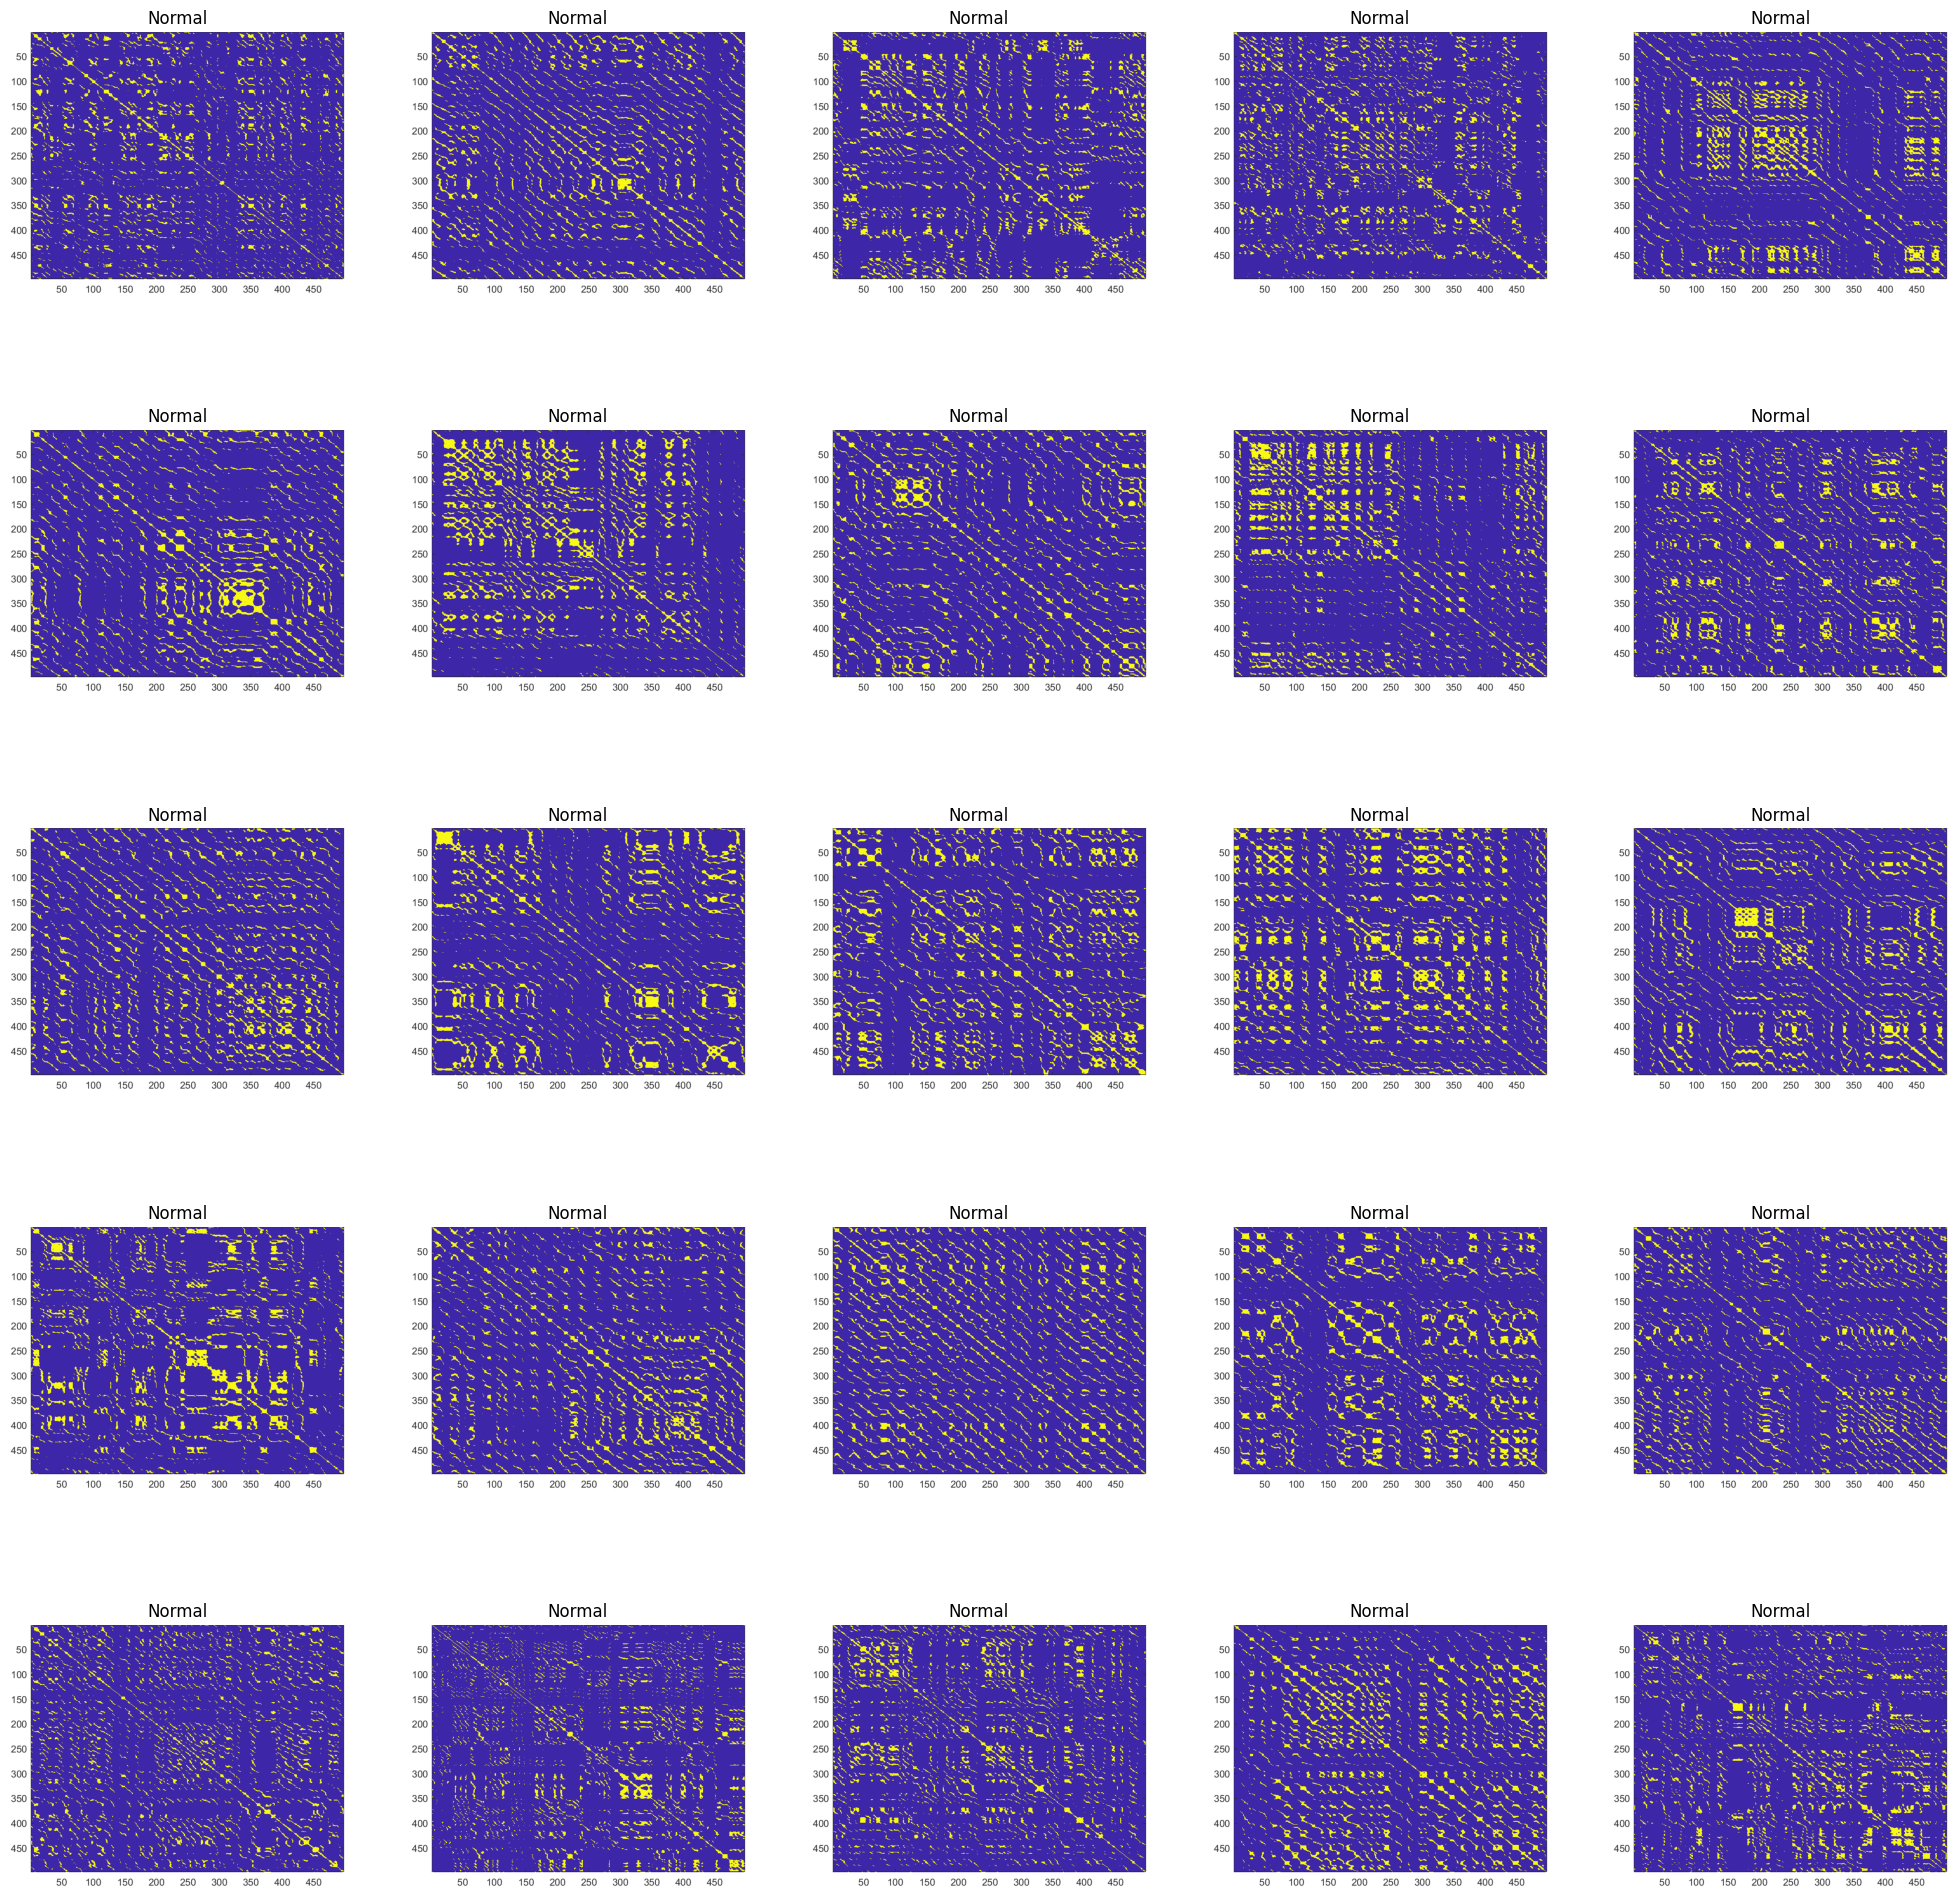

In [ ]:
plt.figure(figsize=(25,25))
temp = df[df['label']==1]['images']
start = random.randint(0, len(temp))
files = temp[start:start+25]

for index, file in enumerate(files):
  plt.subplot(5,5, index+1)
  img=load_img(file)
  img=np.array(img)
  plt.imshow(img)
  plt.title('Normal')
  plt.axis('off')

In [ ]:
import seaborn as sns
sns.countplot(df['label'])

In [8]:
df['label'] = df['label'].astype('str')

input split

In [10]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=42, shuffle = False)

data generation for images

In [11]:
from keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    rescale = 1./255,  # normalization of images
)
val_generator = ImageDataGenerator(rescale = 1./255)

In [15]:
from keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    rescale = 1./255,  # normalization of images
    rotation_range = 40, # augmention of images to avoid overfitting
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)
val_generator = ImageDataGenerator(rescale = 1./255)

train_iterator = train_generator.flow_from_dataframe(
    train,
    x_col='images',
    y_col='label',
    target_size=(128,128),
    batch_size=512,
    class_mode='binary'
)

val_iterator = val_generator.flow_from_dataframe(
    test,
    x_col='images',
    y_col='label',
    target_size=(128,128),
    batch_size=512,
    class_mode='binary'
)

Found 4320 validated image filenames belonging to 2 classes.
Found 1080 validated image filenames belonging to 2 classes.


Model Creation

In [12]:
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense

model = Sequential([
                    Conv2D(16, (3,3), activation='relu', input_shape=(128,128,3)),
                    MaxPool2D((2,2)),
                    Conv2D(32, (3,3), activation='relu'),
                    MaxPool2D((2,2)),
                    Conv2D(64, (3,3), activation='relu'),
                    MaxPool2D((2,2)),
                    Flatten(),
                    Dense(512, activation='relu'),
                    Dense(1, activation='sigmoid')
])

In [13]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

In [18]:
history = model.fit(train_iterator, epochs=20, validation_data=val_iterator)

Epoch 1/10
9/9 [==============================] - 87s 9s/step - loss: 0.7163 - accuracy: 0.4993 - val_loss: 0.6919 - val_accuracy: 0.6417
Epoch 2/10
9/9 [==============================] - 83s 9s/step - loss: 0.6930 - accuracy: 0.4947 - val_loss: 0.6905 - val_accuracy: 0.5019
Epoch 3/10
9/9 [==============================] - 90s 10s/step - loss: 0.6915 - accuracy: 0.5465 - val_loss: 0.6880 - val_accuracy: 0.5046
Epoch 4/10
9/9 [==============================] - 81s 9s/step - loss: 0.6886 - accuracy: 0.5544 - val_loss: 0.6733 - val_accuracy: 0.4991
Epoch 5/10
9/9 [==============================] - 83s 9s/step - loss: 0.6800 - accuracy: 0.5773 - val_loss: 0.6611 - val_accuracy: 0.4963
Epoch 6/10
9/9 [==============================] - 84s 9s/step - loss: 0.6561 - accuracy: 0.6317 - val_loss: 0.5680 - val_accuracy: 0.7231
Epoch 7/10
9/9 [==============================] - 82s 9s/step - loss: 0.6056 - accuracy: 0.7060 - val_loss: 0.4353 - val_accuracy: 0.8907
Epoch 8/10
9/9 [=================

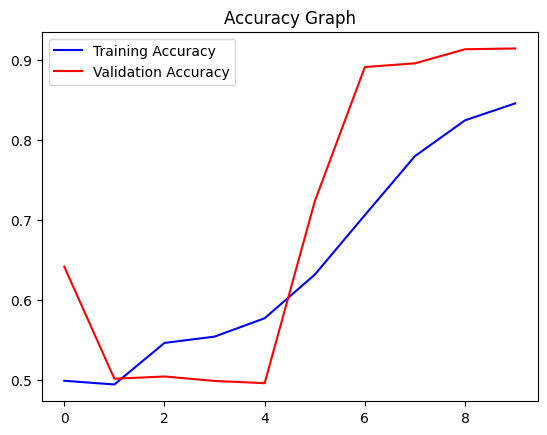

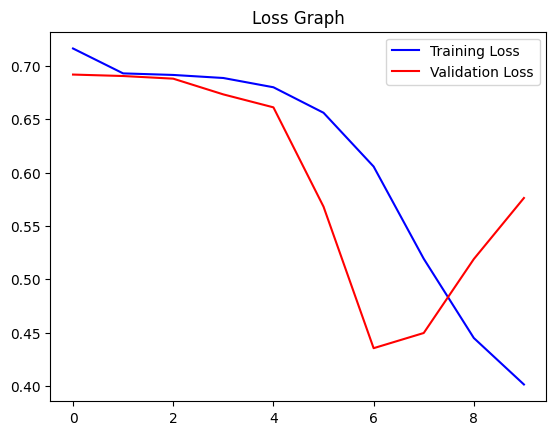

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

Test with Real Image

In [ ]:
image_path = "test.jpg" # path of the image
img = load_img(image_path, target_size=(128, 128))
img = np.array(img)
img = img / 255.0 # normalize the image
img = img.reshape(1, 128, 128, 3) # reshape for prediction
pred = model.predict(img)
if pred[0] > 0.5:
    label = 'Dog'
else:
    label = 'Cat'
print(label)

In [ ]:
# loading images
A1 = ["%0d" % x for x in range(500)] #creating a list of numbers
Address1='pic_norm17_' # main address of images
Address2 = '/content/drive/MyDrive/RQA_norm_pics/' # main address
ALL_img_norm = []

for i in range(1,300):
    ID_img1=Address1+A1[i] #address of one image
    Address3 =  Address2+ID_img1+'.png'
    img1 = mpimg.imread(Address3)
    ALL_img_norm.append(img1) # all images
    print(i)

ALL_img_norm = tf.convert_to_tensor(ALL_img_norm)

In [ ]:
# loading images
A2 = ["%0d" % x for x in range(500)] #creating a list of numbers
Address4='pic_OCD17_' # main address of images
Address5 = '/content/drive/MyDrive/RQA_OCD_pics/' # main address
ALL_img_OCD = []

for i in range(1,300):
    ID_img2=Address1+A2[i] #address of one image
    Address6 =  Address2+ID_img2+'.png'
    img2 = mpimg.imread(Address3)
    ALL_img_OCD.append(img2) # all images
    print(i)

ALL_img_OCD = tf.convert_to_tensor(ALL_img_OCD)

In [ ]:
ALL_img_norm.shape

TensorShape([299, 569, 725, 3])

In [ ]:
test_img_norm = []

for i in range(400,500):
    ID_img3=Address1+A1[i] #address of one image
    Address4 =  Address2+ID_img1+'.png'
    img4 = mpimg.imread(Address4)
    test_img_norm.append(img4) # all images
    print(i)

ALL_test_img_norm = tf.convert_to_tensor(test_img_norm)

In [ ]:
ALL_test_img_norm.shape

TensorShape([100, 569, 725, 3])

In [ ]:
test_img_OCD = []

for i in range(400,500):
    ID_img4=Address1+A2[i] #address of one image
    Address6 =  Address2+ID_img4+'.png'
    img5 = mpimg.imread(Address3)
    test_img_OCD.append(img5) # all images
    print(i)

ALL_test_img_OCD = tf.convert_to_tensor(test_img_OCD)

In [ ]:
ALL_test_img_OCD.shape

TensorShape([100, 569, 725, 3])

In [ ]:
test = tf.concat([ALL_test_img_OCD,ALL_test_img_norm],0)

In [ ]:
train = tf.concat([ALL_img_OCD,ALL_img_norm],0)

In [ ]:
test.shape

TensorShape([200, 569, 725, 3])

In [ ]:
test_images = test.reshape((2, 569*725*3))

AttributeError: ignored

In [ ]:
test_images = ALL_img_norm[201:-1,:, :, :]
test_images.shape

In [ ]:
train_images = train_images.reshape((60000, 784)) # transforme from 3D to 2D
test_images = test_images.reshape((10000, 784))

train_images = train_images.astype('float32') /255 # normalize
test_images = test_images.astype('float32') /255

train_labels = to_categorical(train_labels) # normalize labels
test_labels = to_categorical(test_labels)